# Importing the necessary libraries

In [1]:
import os
import cv2
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, v_measure_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input


# Analyzing the Data

Let's analyze the dataset I choose for my image classification project.

In [2]:
def total_dataset_size(directory):
    total_images = 0
    total_size = 0
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            image_files = os.listdir(label_dir)
            total_images += len(image_files)
            total_size += sum(os.path.getsize(os.path.join(label_dir, img)) for img in image_files)
    
    total_size_MB = total_size / (1024 * 1024)  # Convert bytes to MB
    return total_images, total_size_MB

def print_total_dataset_size(total_images, total_size_MB):
    print(f"Total Number of Images: {total_images}")
    print(f"Total Dataset Size: {total_size_MB:.2f} MB")

# Usage
total_images, total_size_MB = total_dataset_size('/kaggle/input/flowers-recognition/flowers/')
print_total_dataset_size(total_images, total_size_MB)


Total Number of Images: 4317
Total Dataset Size: 228.08 MB


This dataset consists of 4,317 images of flowers, including rose, dandelion, sunflower, daisy, and tulip. The dataset size is 228 MB, which is relatively small but manageable compared to larger datasets, and it allows for faster experimentation.

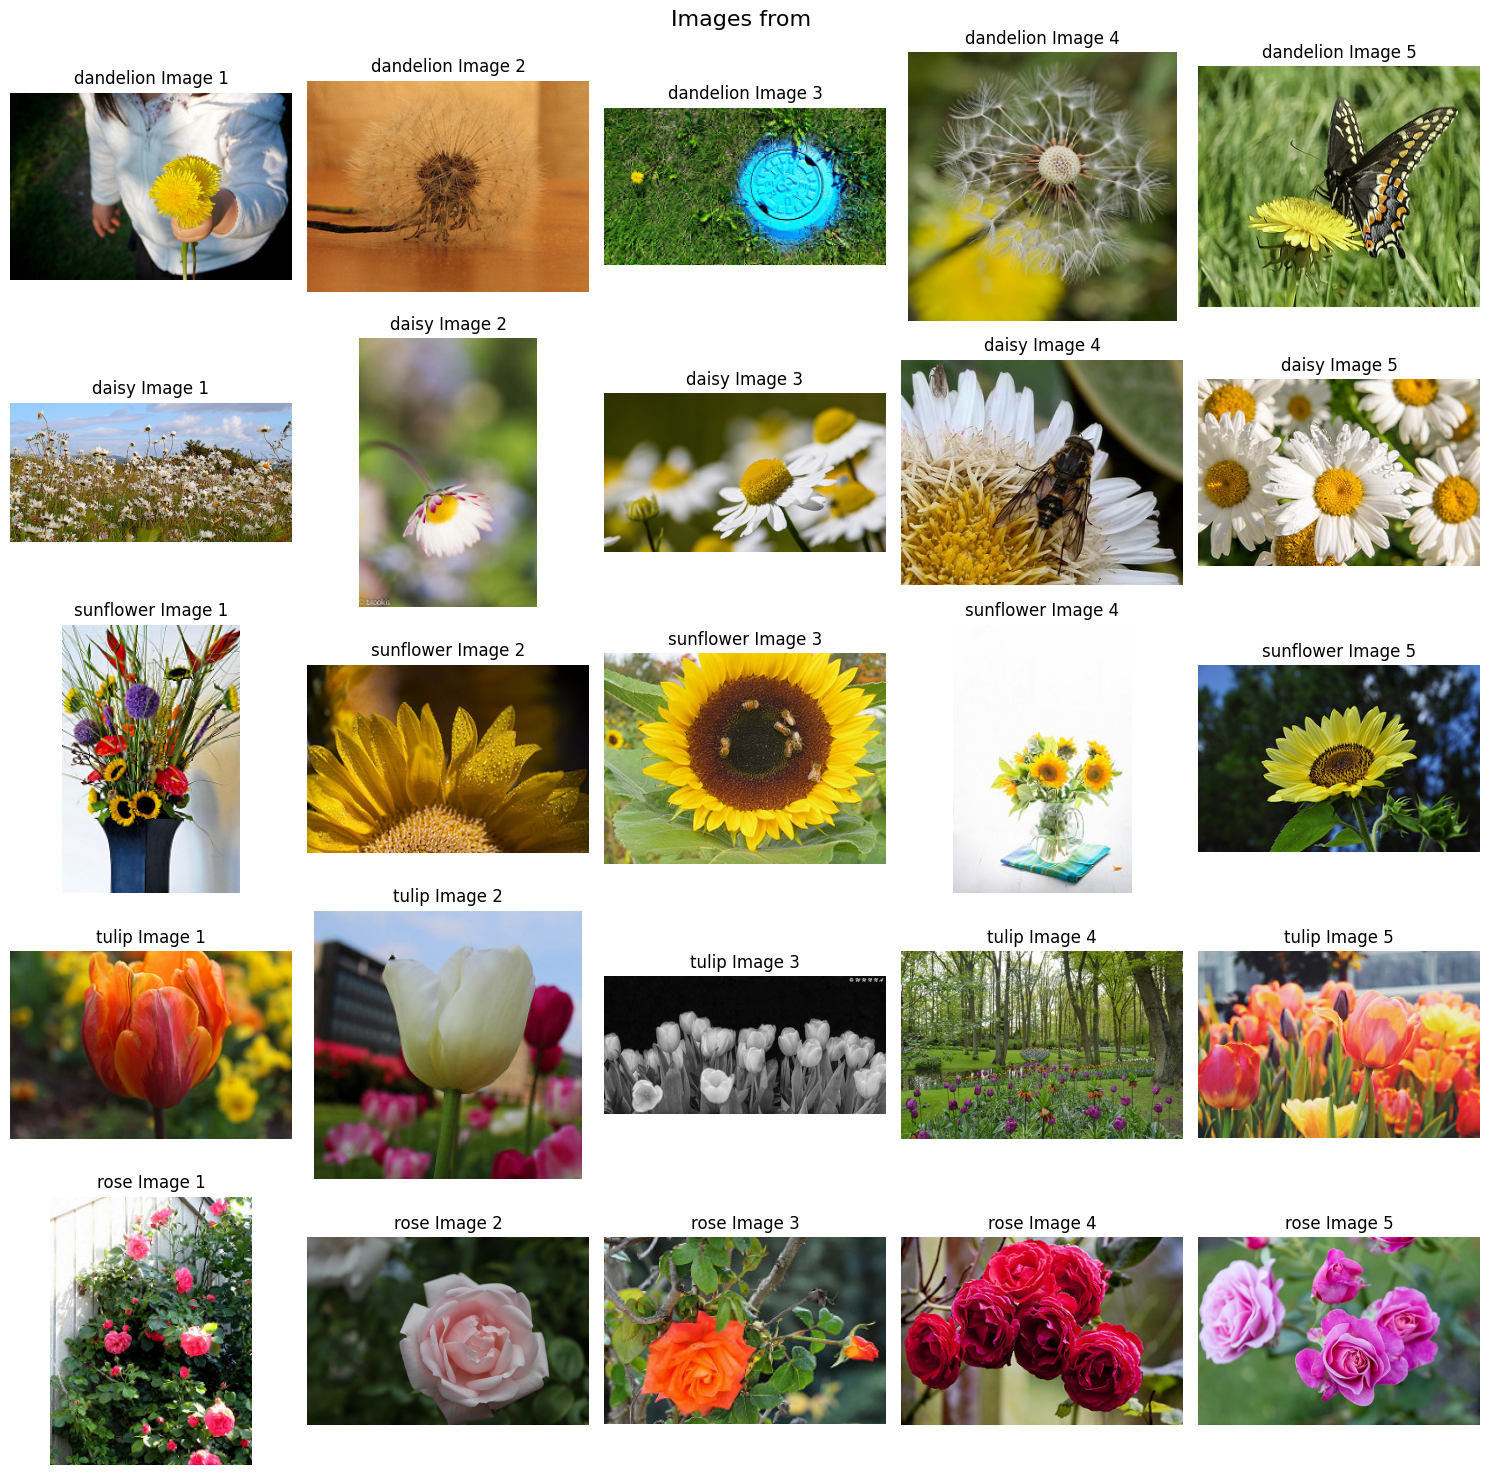

In [3]:
def display_images(directory, num_images=5, preprocess=False):
    labels = [label for label in os.listdir(directory) if os.path.isdir(os.path.join(directory, label))]
    fig, axes = plt.subplots(len(labels), num_images, figsize=(15, len(labels) * 3))
    fig.suptitle(f"Images from {directory.split('/')[-1]}", fontsize=16)
    
    for i, label in enumerate(labels):
        label_dir = os.path.join(directory, label)
        image_files = os.listdir(label_dir)
        random.shuffle(image_files)
        for j in range(num_images):
            image_path = os.path.join(label_dir, image_files[j])
            if preprocess:
                img = preprocess_image(image_path)
            else:
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if img is not None:
                axes[i, j].imshow(img)
            else:
                axes[i, j].imshow(np.ones((128, 128, 3)))  # Display a blank image if preprocessing fails
            axes[i, j].set_title(f"{label} Image {j+1}")
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
display_images('/kaggle/input/flowers-recognition/flowers/')

Here are the images from the five classes of the dataset. As you can see, they are of different sizes and are colorful.

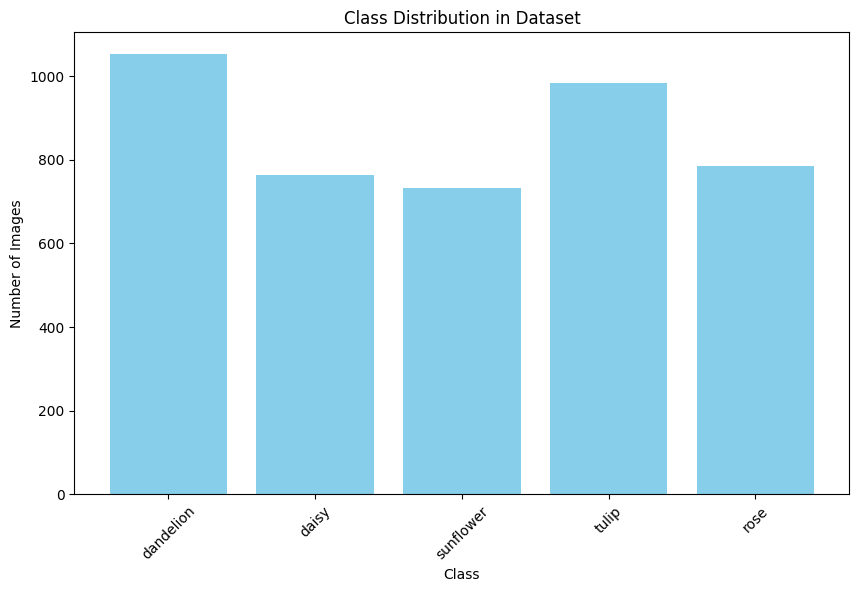

In [4]:
def plot_class_distribution(directory):
    labels = [label for label in os.listdir(directory) if os.path.isdir(os.path.join(directory, label))]
    counts = [len(os.listdir(os.path.join(directory, label))) for label in labels]
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution in Dataset')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution('/kaggle/input/flowers-recognition/flowers/')


In this graph, we can see that all of the classes are distributed nearly equally, so in the next steps of my project, I will not need to implement techniques like data augmentation for my dataset.

# Preprocessing

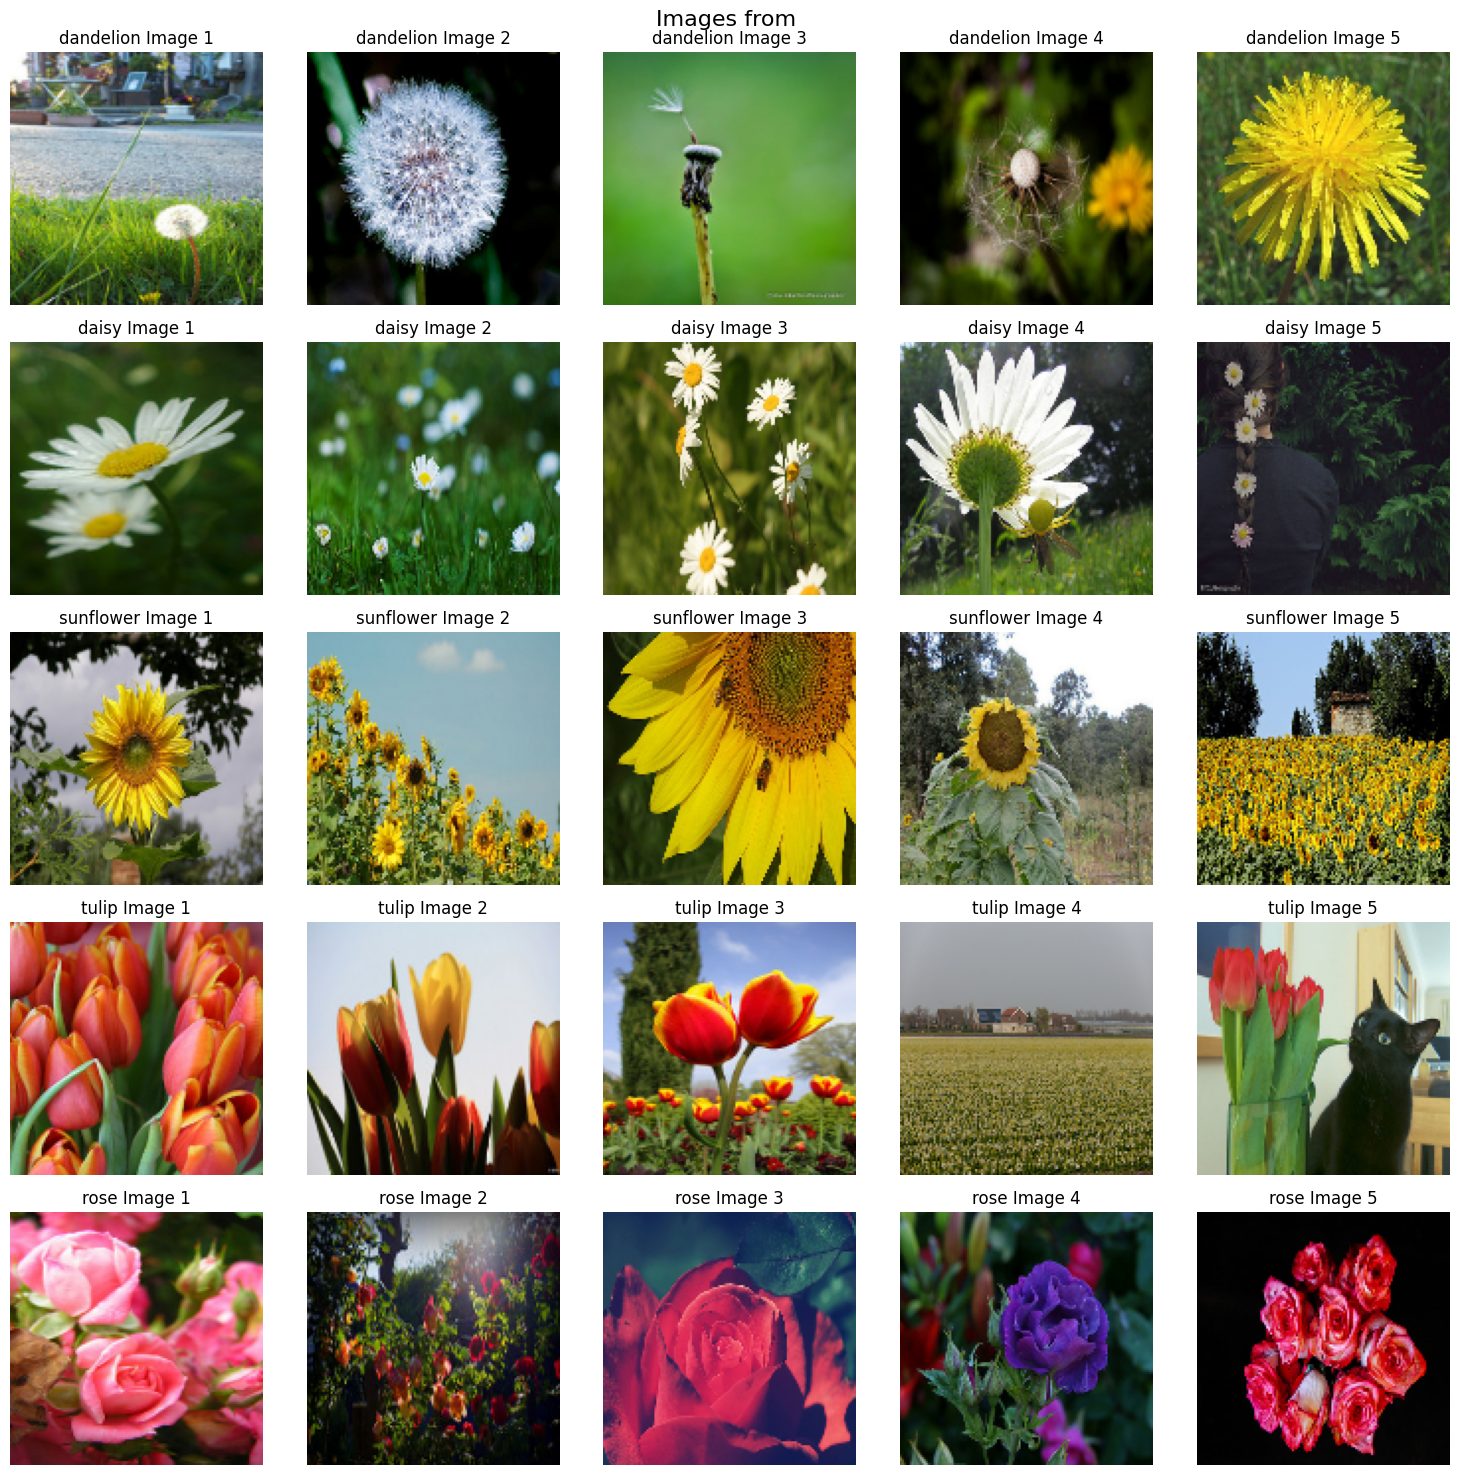

In [5]:
def preprocess_image(image_path, img_size=(128, 128)):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img_resized = cv2.resize(img, img_size)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_normalized = img_rgb / 255.0
    return img_normalized

display_images('/kaggle/input/flowers-recognition/flowers/', preprocess=True)


 The preprocess_image function specifically handles resizing, color conversion, and normalization of images. This preprocessing step is crucial for preparing images to be fed into a machine learning model, ensuring consistency in image dimensions and pixel value. Here are the images after preprocessing. Seeing these images will help us understand what the function does better.

In [6]:
def load_images(directory, img_size=(128, 128)):
    X = []
    y = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        
        if os.path.isdir(label_dir):
            for filename in os.listdir(label_dir):
                image_path = os.path.join(label_dir, filename)
                
                # Preprocess the image
                img_preprocessed = preprocess_image(image_path, img_size)
                
                if img_preprocessed is not None:
                    X.append(img_preprocessed)
                    y.append(label)
    
    return np.array(X), np.array(y)


## Splitting training and test dataset

Now it is time for splitting the dataset into two sets which are for training and testing. Training and test datasets will be used in supervised learning. 

In [7]:
# Load data
X, y = load_images('/kaggle/input/flowers-recognition/flowers/')

# Flatten images for K-Means
X_flattened = X.reshape(X.shape[0], -1)

# Convert string labels to integers
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_int, test_size=0.2, random_state=42, stratify=y_int)

# Flatten the images for Rnadom Forest
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)


In this code snippet, we can see that the data used for K-means and Random Forest are flattened. This is because both algorithms require the data to be in the form of feature vectors. By flattening the data, we convert multi-dimensional matrices into one-dimensional vectors, which allows the algorithms to process the data effectively.

# Choosing the Algorithms
## Supervised
### CNN

For this flower classification problem, I chose two unsupervised algorithms. The first one is CNN, which is quite popular for image-related projects.

In [8]:
def train_cnn_model(input_shape=(128, 128, 3), num_classes=5, X_train=None, y_train=None):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
    
    return model

Here are the layers that I used for my model and their purposes:

* **Input Layer:** Takes images of shape input_shape. 
* **Convolutional Layers:** Three convolutional layers (Conv2D) with increasing filter sizes (32, 64, and 128) and ReLU activation, each followed by a max pooling layer (MaxPooling2D) to reduce the spatial dimensions.
* **Flatten Layer:** Converts the 2D feature maps into a 1D vector.
* **Dense Layers:** Fully connected layers where the first dense layer has 128 units with ReLU activation, followed by a dropout layer with a rate of 0.5 to prevent overfitting.
* **Output Layer:** A final dense layer with num_classes units and softmax activation to produce class probabilities.

In [9]:
# Train the CNN model
cnn_model = train_cnn_model(X_train=X_train, y_train=y_train)

# Predict the labels for the test set
cnn_pred = cnn_model.predict(X_test)
y_pred_cnn = np.argmax(cnn_pred, axis=1)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 56s 550ms/step - accuracy: 0.3200 - loss: 1.5237 - val_accuracy: 0.4538 - val_loss: 1.2388
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 547ms/step - accuracy: 0.5039 - loss: 1.1939 - val_accuracy: 0.5260 - val_loss: 1.1082
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 546ms/step - accuracy: 0.5774 - loss: 1.0532 - val_accuracy: 0.6272 - val_loss: 0.9849
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 542ms/step - accuracy: 0.6526 - loss: 0.9052 - val_accuracy: 0.6243 - val_loss: 0.9790
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 53s 539ms/step - accuracy: 0.6702 - loss: 0.8514 - val_accuracy: 0.6358 - val_loss: 0.9775
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 54s 546ms/step - accuracy: 0.7488 - loss: 0.6603 - val_accuracy: 0.6618 - val_loss: 1.0118
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 53s 537ms/step - accuracy: 0.7818 - loss: 0.5739 - val_accuracy: 0.6792 - val_loss: 1.0583
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 83s 543ms/step - accuracy: 0.7972 - loss: 0.5626 - val_accu

### Random Forest

The second algorithm I chose is Random Forest. Random Forest is popular because of its ability to handle large datasets with high dimensionality. It operates by creating a multitude of decision trees during training and outputs the class that is the mode of the classes (for classification) or the mean prediction (for regression) of the individual trees.

In [10]:
def train_random_forest(X_train, y_train):
    model = RandomForestClassifier(
        n_estimators=500,          # Number of trees
        max_depth=None,            # Depth of each tree
        min_samples_split=2,       # Minimum number of samples required to split an internal node
        min_samples_leaf=1,        # Minimum number of samples required to be at a leaf node
        max_features='sqrt',       # Number of features to consider when looking for the best split
        criterion='gini',          # Function to measure the quality of a split
        random_state=42,           # Seed for random number generator
        class_weight='balanced'    # Adjust weights inversely proportional to class frequencies
    )
    model.fit(X_train, y_train)
    return model

Here are the parameters I choosed for my model and their purposes:
* **n_estimators=500:** Specifies 500 decision trees in the forest.
* **max_depth=None:** Trees are allowed to grow until all leaves are pure or contain fewer than min_samples_split samples.
* **min_samples_split=2:** A node must have at least 2 samples to be split.
* **min_samples_leaf=1:** A leaf node must have at least 1 sample.
* **max_features='sqrt':** Each tree considers the square root of the total number of features when looking for the best split.
* **criterion='gini':** Uses the Gini impurity measure to evaluate the quality of splits.
* **random_state=42:** Sets the seed for the random number generator for reproducibility.
* **class_weight='balanced':** Adjusts the weights of classes inversely proportional to their frequencies to handle class imbalance.

In [11]:
# Train the Random Forest model
model_rf = train_random_forest(X_train_flattened, y_train)

# Predict the labels for the test set
y_pred_rf = model_rf.predict(X_test_flattened)

## Unsupervised
### K-means

For unsupervised learning, I chose K-Means, which is not typically preferred for image classification.

In [12]:
# Apply PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_flattened)

# Perform K-Means clustering
num_clusters = len(np.unique(y))  # Set the number of clusters to the number of unique labels
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)  # Explicitly set n_init
y_pred_km = kmeans.fit_predict(X_pca)

# Apply PCA on the test set
X_test_pca = pca.transform(X_test_flattened)

# Perform K-Means clustering on the test set
y_pred_km_test = kmeans.predict(X_test_pca)


Here are the explanation for the steps of unsupervised learning:

* **Apply PCA:** Reduces the dimensionality of the flattened training data (X_flattened) to 50 principal components using PCA (Principal Component Analysis).

* **Perform K-Means Clustering:**

Initializes a K-Means clustering model with the number of clusters equal to the number of unique labels in y (which matches the number of classes).
Trains the K-Means model on the PCA-transformed training data (X_pca) and predicts cluster labels (y_pred_km).
Apply PCA on the Test Set: Transforms the flattened test data (X_test_flattened) using the same PCA model to obtain its PCA representation (X_test_pca).

* **Perform K-Means Clustering on the Test Set:**

Uses the trained K-Means model to predict cluster labels for the PCA-transformed test data (y_pred_km_test).

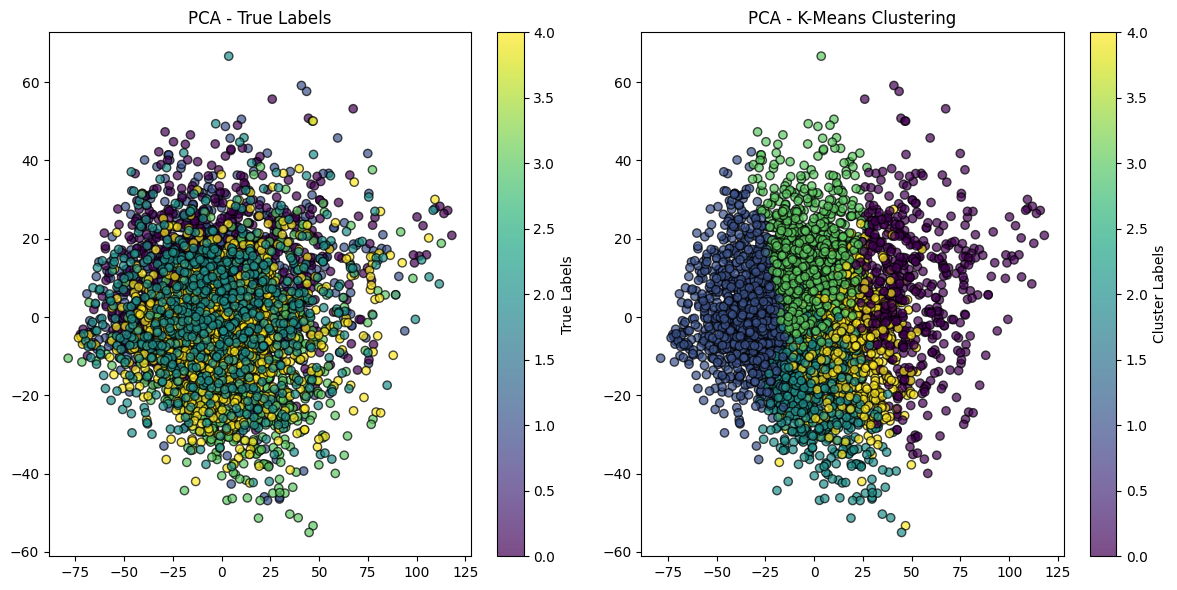

In [13]:
# Plot PCA components
plt.figure(figsize=(12, 6))

# Plot PCA results
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_int, cmap='viridis', marker='o', edgecolor='k', alpha=0.7)
plt.colorbar(label='True Labels')
plt.title('PCA - True Labels')

# Plot K-Means clustering results
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_km, cmap='viridis', marker='o', edgecolor='k', alpha=0.7)
plt.colorbar(label='Cluster Labels')
plt.title('PCA - K-Means Clustering')

plt.tight_layout()
plt.show()

By these two graphs we can say that K-Means Clustering did not work well on the flower dataset. 

# Evaluation

Here are the evaluation metrices and their explanations:
### For supervised

#### 1. **Accuracy**
- **Definition**: The proportion of correctly classified instances (both true positives and true negatives) out of the total number of instances.
- **Formula**: 
  \[
  \text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Number of Instances}}
  \]
- **Use Case**: Provides a general measure of how well the model performs overall, but can be misleading if classes are imbalanced.

#### 2. **Precision**
- **Definition**: The proportion of true positive instances out of all instances classified as positive.
- **Formula**: 
  \[
  \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
  \]
- **Use Case**: Useful when the cost of false positives is high. For instance, in spam detection, you want to minimize non-spam emails incorrectly classified as spam.

#### 3. **Recall (Sensitivity or True Positive Rate)**
- **Definition**: The proportion of true positive instances out of all actual positive instances.
- **Formula**: 
  \[
  \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  \]
- **Use Case**: Important when the cost of false negatives is high. For example, in medical diagnoses, you want to identify as many positive cases as possible, even if it means having some false positives.

#### 4. **F1 Score**
- **Definition**: The harmonic mean of precision and recall, providing a balance between them. It is useful when you need a single metric to evaluate a model's performance, especially with imbalanced datasets.
- **Formula**: 
  \[
  \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
  \]
- **Use Case**: Provides a better measure of performance when dealing with uneven class distributions. It balances precision and recall, making it useful in many practical situations.


### For unsupervised
#### 1. **Silhouette Score**
- **Definition**: Measures how similar an object is to its own cluster compared to other clusters. It evaluates both cohesion (how close the object is to other points in the same cluster) and separation (how far the object is from points in other clusters).
- **Range**: -1 to +1. A score close to +1 indicates that the points are well clustered, while a score close to -1 indicates that the points might be incorrectly clustered.

#### 2. **Homogeneity Score**
- **Definition**: Measures how well each cluster contains only members of a single class. It quantifies how much the clusters match the true labels.
- **Range**: 0 to 1. A score of 1 means that all clusters contain only members of a single class.

#### 3. **V-Measure Score**
- **Definition**: Measures the balance between homogeneity and completeness. It assesses how well the clusters match the true class labels by considering both how much of a class is found in a cluster (completeness) and how many clusters of a class there are (homogeneity).
- **Range**: 0 to 1. A score of 1 means perfect balance between homogeneity and completeness.

#### 4. **Adjusted Rand Index (ARI)**
- **Definition**: Measures the similarity between two data clusterings by considering all pairs of points and how often they are clustered together or apart. It adjusts for chance grouping, providing a more accurate assessment of clustering quality.
- **Range**: -1 to 1. A score of 1 indicates perfect agreement between clusterings, while a score close to 0 indicates random clustering. Negative values indicate less than expected agreement by chance.


In [14]:
def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [15]:
def evaluate_unsupervised(X, y, y_pred):
    silhouette_avg = silhouette_score(X, y_pred)
    homogeneity = homogeneity_score(y, y_pred)
    v_measure = v_measure_score(y, y_pred)
    ari = adjusted_rand_score(y, y_pred)

    print(f"Silhouette Score: {silhouette_avg:.4f}")
    print(f"Homogeneity Score: {homogeneity:.4f}")
    print(f"V-Measure Score: {v_measure:.4f}")
    print(f"Adjusted Rand Index: {ari:.4f}")

In [16]:
def plot_confusion_matrix(y_true, y_pred, labels=label_encoder.classes_):
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

Evaluation Metrices and Confusion Matrix for Random Forest
Test Accuracy: 0.5509
Precision: 0.5658
Recall: 0.5509
F1 Score: 0.5425


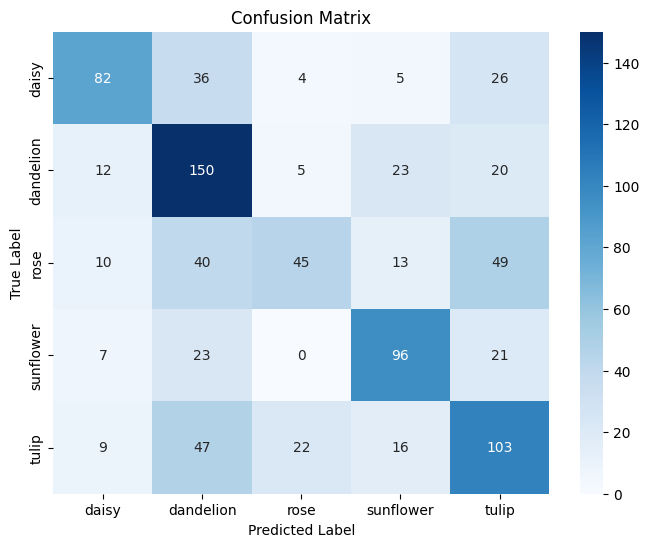

Evaluation Metrices and Confusion Matrix for CNN
Test Accuracy: 0.7153
Precision: 0.7155
Recall: 0.7153
F1 Score: 0.7143


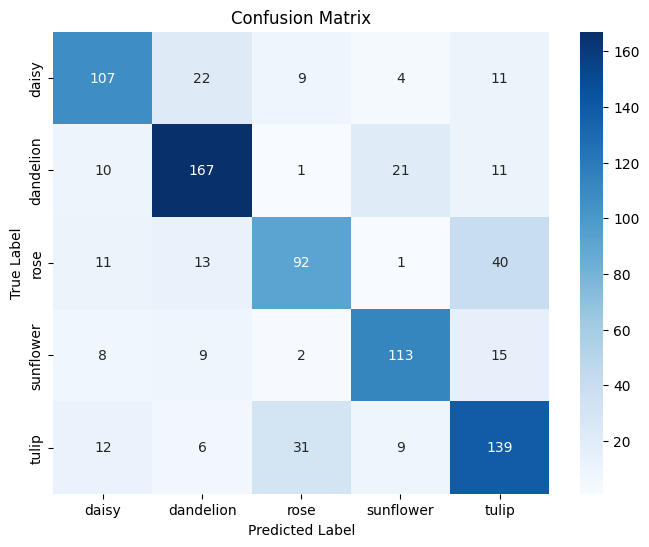

Evaluation Metrices and Confusion Matrix for K-means
 
Silhouette Score: 0.1075
Homogeneity Score: 0.0473
V-Measure Score: 0.0477
Adjusted Rand Index: 0.0331


In [17]:
# Evaluation for Random Forest
print(f"Evaluation Metrices and Confusion Matrix for Random Forest")
evaluate(y_test, y_pred_rf)
plot_confusion_matrix(y_test, y_pred_rf, labels=label_encoder.classes_)

# Evaluation for CNN
print(f"Evaluation Metrices and Confusion Matrix for CNN")
evaluate(y_test, y_pred_cnn)
plot_confusion_matrix(y_test, y_pred_cnn, labels=label_encoder.classes_)

# Evaluation for K-means
print(f"Evaluation Metrices and Confusion Matrix for K-means")
##evaluate(y_test, y_pred_km_test)
print(f" ")
evaluate_unsupervised(X_pca, y_int, y_pred_km)
##plot_confusion_matrix(y_test, y_pred_km_test, labels=label_encoder.classes_)


The results:

1. **CNN (Convolutional Neural Network)**
   - The CNN model demonstrates the best performance among the three algorithms. It shows strong accuracy, precision, recall, and F1 score, indicating effective classification of flower images. CNNs excel in image-related tasks due to their capability to automatically learn and extract features from images, leading to more accurate and balanced classification.

2. **Random Forest**
   - The Random Forest model exhibits moderate performance. While it achieves reasonable precision and recall, its overall accuracy and F1 score are lower than those of the CNN. This suggests that while Random Forest captures some patterns in the data, it does not perform as well in distinguishing between different flower classes compared to the CNN.

3. **K-Means Clustering**
   - K-Means clustering performs the least effectively for this classification task. It shows poor accuracy indicating significant challenges in classifying flower images. Additionally, the clustering evaluation metrics highlight issues with cluster cohesion and separation, and poor alignment with the true labels.

**Summary**: 
The CNN model is the most effective for flower classification, providing the highest accuracy and balanced performance across various metrics. Random Forest offers moderate performance but falls short compared to CNN. K-Means, being an unsupervised clustering method, struggles considerably in this classification context, as reflected by its clustering evaluation metrics.
